### AR & MA Models
In time series, autoregression(AR) and moving average (MA) models provide a simple description of a process in terms of two factors--one for autoregression and the other for moving average. The AR part entails regressing the variable on its own lagged values. The idea is that the previous time period's value can help us predict the current time period's value. The MA part involves modeling the error term as a linear combination of error terms occurring at the same time step and at various times in the past.

### Autoregressive Models
Autoregressive (AR) Model is when present value of a time series can be predicted from using previous values of the same series. It's a regression using its same series, though shifted by a time step, called a lag. The present value is a weighted average of its past values. Both the t-1 and t-2 are lags of the time series y. The error term (noise) is represented as e. The values a1 and a2 are the coefficients of the model.

AR(1) model: $y_{t}$ = $a_{1}$$y_{t-1}$ + $e_{t}$

AR(2) model: $y_{t}$ = $a_{1}$$y_{t-1}$ + $a_{2}$$y_{t-2}$ + $e_{t}$

We typically represent the order of the model as p for an AR model such as AR(p).

### Moving Average Models
Moving average (MA) is a process where the present value of a time series, y, is defined as a linear combination of past errors. The error term (noise) is represented as e. Both the t-1 and t-2 are lags of the time on the errors.

MA(1) model: $y_{t}$ = $m_{1}$$e_{t-1}$ + $e_{t}$

MA(2) model: $y_{t}$ = $m_{1}$$e_{t-1}$ + $m_{2}$$e_{t-2}$ + $e_{t}$

We typically represent the order of the model as q for a MA model such as MA(q).

### ARMA Models
We can combine both Autoregressive and Moving Average models together to create an ARMA model. The time series is regressed on the previous values and the previous errors.

ARMA(1,1) model: $y_{t}$ = $a_{1}$$y_{t-1}$ + $m_{1}$$e_{t-1}$

For ARMA(p, q), p is the order of the AR process and q is the order of the MA process.

## Forecast quality metrics

Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

### Analítica
Vamos a utilizar los datos de ventas de Johnson&Johnson

In [1]:
# librerias
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/jj.csv', index_col=0)
print(len(data))
data.head()

84


,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


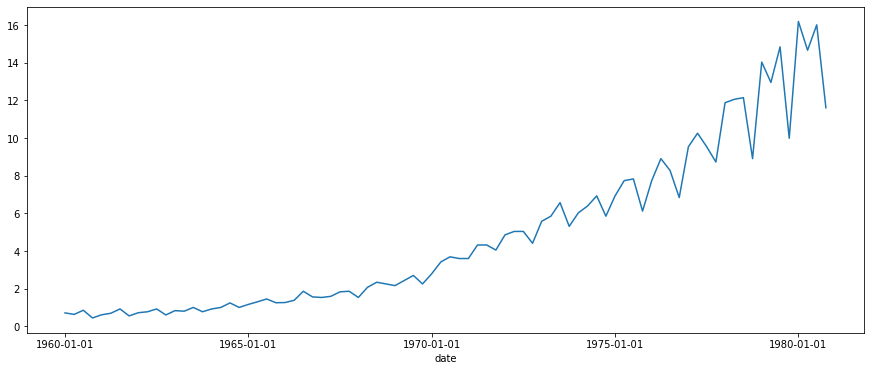

In [3]:
data['data'].plot(figsize=(15,6));

Se aprecia en la gráfica que presenta diferentes estadísticos a lo largo del tiempo.

Representamos sus gráficas de autocorrelación. Vemos que tenemos muy complicado determinar el orden p y q, de cara al modelo ARIMA.

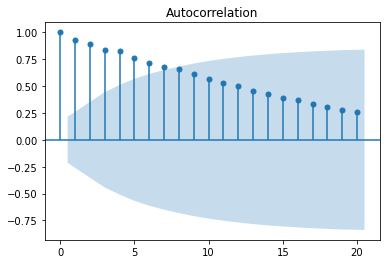

In [4]:
plot_acf(data['data']);

Dividimos en train y test

In [5]:
X = data['data'].values

train = X[:70]
test = X[70:]

## Autoregressive
Tendremos que encontrar el orden de autoregression que mejor encaje con nuestros datos.

In [6]:
model_ar = ARIMA(order=(1, 0, 0))
model_ar_fit = model_ar.fit(train)

In [7]:
predictions = model_ar_fit.predict(14)
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 13.698813449535994


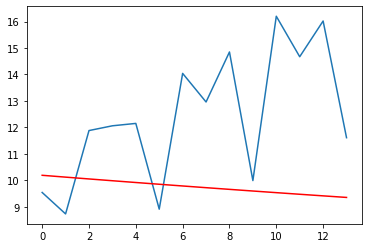

In [8]:
plt.plot(test)
plt.plot(predictions,color='red');

No parece que de buen resultado el AR(1,0,0). Probemos diferentes lags, a ver cuál sería el mejor

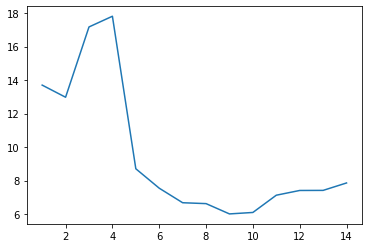

In [9]:
lags = []
mse = []
for lag in range(1, 15):
    try:
        model_ar = ARIMA(order=(lag, 0, 0))
        model_ar_fit = model_ar.fit(train)
        lags.append(lag)
        predictions = model_ar_fit.predict(14)
        mse.append(mean_squared_error(test, predictions))
    except:
        continue
    
plt.plot(lags, mse);

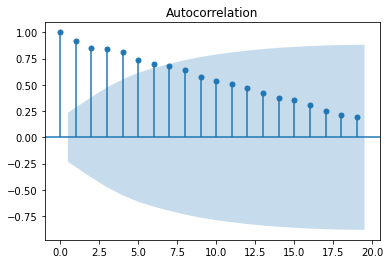

In [10]:
plot_acf(train);

Un parámetro p=1, p=2 o p=5 parece que da buen resultado, pero aun asi es muy alto el error.

## Moving Average
En este caso tendremos en cuenta los errores. El problema es que si tenemos muchos errores al principio, los iremos arrastrando durante las predicciones.

In [11]:
model_ar = ARIMA(order=(0, 0, 1))
model_ar_fit = model_ar.fit(train)

In [12]:
predictions = model_ar_fit.predict(14)
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 87.15679102128321


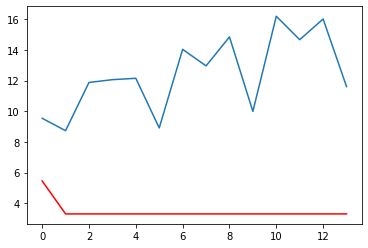

In [13]:
plt.plot(test)
plt.plot(predictions,color='red');

No está dando buen resultado. Probaremos entonces varios lags

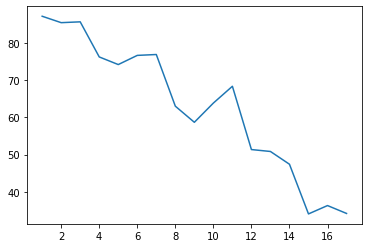

In [14]:
lags = []
mse = []
for lag in range(1, 20):
    try:
        model_ar = ARIMA(order=(0, 0, lag))
        model_ar_fit = model_ar.fit(train)
        predictions = model_ar_fit.predict(14)
        lags.append(lag)
        mse.append(mean_squared_error(test, predictions))
    except:
        continue
    
plt.plot(lags, mse);

Parece que según vamos aumentando el parámetro `q` del modelo Moving Average, va disminuyendo el error, pero aun así es bastante grande.

## ARIMA
En el arima no solo influyen los parámetros `p` y `q`, sino que también tendremos en cuenta `d`. Parametro con el que diferenciaremos la serie y conseguiremos que sea estacionaria.

Ahora bien, ¿cuál es la mejor combinación de parámetros? Tendremos que realizar varias pruebas. Para comparar los modelos se suele utilizar el AIC.

### AIC
Akaike’s Information Criterion

![imagen](./img/aic.png)

k es el número de parámetros del modelo estadístico y L es el máximo valor de la función de verosimilitud para el modelo estimado. La función de verosimilitud permite realizar inferencias a partir de u conjunto de observaciones.

Se utiliza para seleccionar el mejor modelo, que será el que tiene menor AIC. El AIC depende mucho de cada dato, y es una medida de comparación entre modelos, no de presentación de resultados. Un AIC bajo no quiere decir que el modelo sea muy bueno. Por tanto, AIC no nos dice nada sobre la calidad del modelo en terminos absolutos.


#### ¿Cómo conseguir los mejores p, d, q?

In [15]:
import itertools

p = range(0,5)
d = range(0,5)
q = range(0,5)

pdq = list(itertools.product(p, d, q))
pdq[:5]

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4)]

In [16]:
results = []
for param in pdq:
    try:
        model_arima = ARIMA(order=param)
        model_arima_fit = model_arima.fit(train)
        results.append((param,model_arima_fit.aic()))
    except:
        continue
    

In [17]:
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC']).sort_values('AIC')
resultados_df.head()

,ARIMA params,AIC
87,"(3, 2, 2)",36.995089
111,"(4, 2, 1)",37.885851
88,"(3, 2, 3)",38.293137
112,"(4, 2, 2)",38.626643
113,"(4, 2, 3)",40.211607


Ya tenemos la mejor combinación de parámetros para el ARIMA. Probemos el modelo

In [18]:
best_model = ARIMA(order=(3,2,2))
best_model.fit(train)
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(3, 2, 2)   Log Likelihood                 -11.498
Date:                Tue, 20 Apr 2021   AIC                             36.995
Time:                        09:33:44   BIC                             52.532
Sample:                             0   HQIC                            43.151
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0175      0.002      7.190      0.000       0.013       0.022
ar.L1         -1.1101      0.054    -20.607      0.000      -1.216      -1.005
ar.L2         -1.0936      0.050    -21.789      0.0

In [19]:
predictions = best_model.predict(14)
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 3.945145231944923


### Auto ARIMA

In [20]:
stepwise_model = auto_arima(train,
                            start_p=1,
                            start_q=1,
                            max_d=3,
                            max_p=5,
                            max_q=5,
                            stationary=False,
                            trace=True)

print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=138.619, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=196.672, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=180.443, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=140.942, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=113.935, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=166.323, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=47.310, Time=0.12 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=44.000, Time=0.25 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=43.451, Time=0.30 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=51.018, Time=0.26 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=40.757, Time=0.33 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=44.609, Time=0.29 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=42.886, Time=0.38 s

In [21]:
model = ARIMA(order=(3,2,2))
model.fit(train)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(3, 2, 2)   Log Likelihood                 -11.498
Date:                Tue, 20 Apr 2021   AIC                             36.995
Time:                        09:33:51   BIC                             52.532
Sample:                             0   HQIC                            43.151
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0175      0.002      7.190      0.000       0.013       0.022
ar.L1         -1.1101      0.054    -20.607      0.000      -1.216      -1.005
ar.L2         -1.0936      0.050    -21.789      0.0

## ARIMAX
La X viene de exogenous. Significa que le podemos añadir una variable externa con la que entrenar el modelo.

Vamos a probar con los datos de la bolsa. Primero un auto_arima con los datos a cierre. Y después un auto_arima acompañado de los datos de apertura de bolsa, a ver cuánto ayudan a predecir el cierre.

In [22]:
stock_df = pd.read_csv('data/FB.csv', header=0, index_col=0)
print(len(stock_df))
stock_df.head()

1259


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-08,76.180000,77.250000,75.400002,76.519997,76.519997,25733900
2014-12-09,75.199997,76.930000,74.779999,76.839996,76.839996,25358600
2014-12-10,76.650002,77.550003,76.070000,76.180000,76.180000,32210500
2014-12-11,76.519997,78.519997,76.480003,77.730003,77.730003,33462100
2014-12-12,77.160004,78.879997,77.019997,77.830002,77.830002,28091600


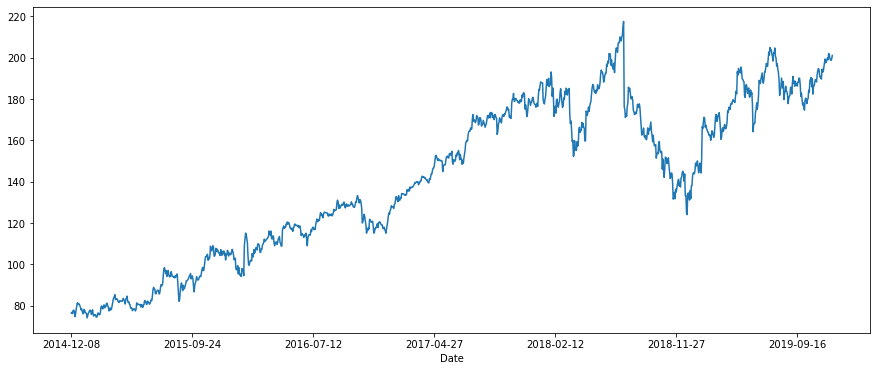

In [23]:
stock_df['Close'].plot(figsize=(15,6));

Vemos primero ejemplo sin variable exogena

In [24]:
train = stock_df['Close'][0:1240].values
test = stock_df['Close'][1240:].values

Vamos a probar varios ARIMAS, a ver cuál sería la mejor combinación de hiperparámetros.

In [25]:
stepwise_model = auto_arima(train,
                            start_p=1,
                            start_q=1,
                            max_d=3,
                            max_p=5,
                            max_q=5,
                            stationary=False,
                            trace=True,
                           stepwise=True)
print(stepwise_model.aic())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5973.080, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5975.597, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5977.174, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5977.161, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5975.049, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5974.760, Time=0.74 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5978.841, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5978.892, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5973.656, Time=0.24 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 5.561 seconds
5973.07958300314


Ya lo tenemos, ahora montaremos el modelo con esos hiperparámetros y vemos que AIC tiene.

In [26]:
model = ARIMA(order=(1,1,1))
model.fit(train)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1240
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2982.540
Date:                Tue, 20 Apr 2021   AIC                           5973.080
Time:                        09:35:41   BIC                           5993.568
Sample:                             0   HQIC                          5980.785
                               - 1240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0125      0.012      1.065      0.287      -0.010       0.035
ar.L1          0.8642      0.086     10.019      0.000       0.695       1.033
ma.L1         -0.9007      0.075    -11.983      0.0

In [27]:
predictions = model.predict(19)
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 45.03417171677588


Vamos ahora a compararlo con el mismo modelo, pero en este caso le añadimos una variable exogena al entrenamiento

In [28]:
model = ARIMA(order=(1,1,1))
model.fit(train,
        exogenous=stock_df['Open'][:1240].values.reshape(-1, 1))
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1240
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2601.451
Date:                Tue, 20 Apr 2021   AIC                           5212.902
Time:                        09:35:58   BIC                           5238.512
Sample:                             0   HQIC                          5222.534
                               - 1240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      0.991      0.321      -0.000       0.001
x1             0.9972      0.003    387.959      0.000       0.992       1.002
ar.L1         -0.1287      0.024     -5.448      0.0

Reduce bastante el AIC

Probemos a entrenar el auto arima con la variable exogena

In [29]:
model = auto_arima(train,
                  exogenous = stock_df['Open'][:1240].values.reshape(-1, 1),
                  start_p = 1,
                  start_1 = 1,
                  max_d = 3,
                  max_p = 5,
                  max_q = 5,
                  stationary=False,
                  trace=True)
                  
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5208.896, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5226.894, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5207.698, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5206.018, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5225.469, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5206.237, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5206.773, Time=0.45 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5204.065, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5204.309, Time=0.78 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5204.812, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5205.764, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5206.963, Time=1.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 5.407 seconds
5204.064769420869


Probemos varias variables exogenas

NOTA: para este apartado se utiliza el valor 'Low', que en la vida real no lo tendriamos para realizar la predicción.

In [30]:
model = auto_arima(train,
                  exogenous = stock_df[['Open', 'Low']][:1240].values.reshape(-1, 2),
                  start_p = 1,
                  start_1 = 1,
                  max_d = 3,
                  max_p = 5,
                  max_q = 5,
                  stationary=False,
                  trace=True)
                  
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4090.146, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4733.379, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4453.973, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4086.215, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4731.700, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4082.122, Time=0.81 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4077.060, Time=0.87 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4265.464, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4075.150, Time=1.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4201.107, Time=0.43 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4076.431, Time=1.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4076.740, Time=1.97 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4077.184, Time=1.61 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4177.095, Time=0.55 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

## SARIMA
Veamos cómo podemos predecir con datos que tienen estacionalidad, es decir, que cuentan con un patrón que se repite a lo largo del tiempo.

In [31]:
df = pd.read_csv('data/a10.csv', parse_dates=['date'], index_col='date')
print(len(df))
df.head()

204


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


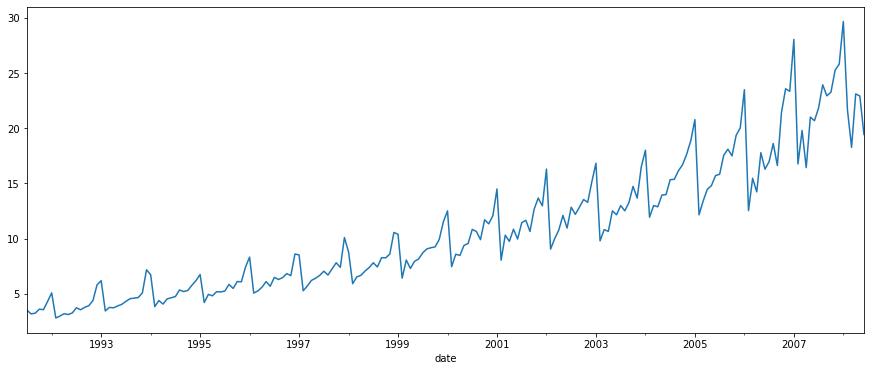

In [32]:
df['value'].plot(figsize=(15,6));

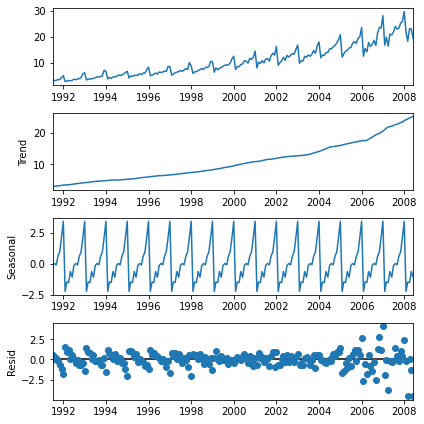

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(df[['value' ]], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_add.plot();

In [34]:
X = df[['value']]
train, test = X[:-20], X[-20:]

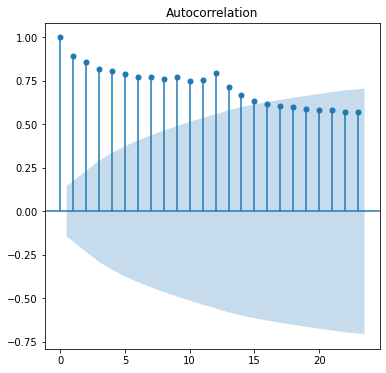

In [35]:
plot_acf(train);

Probemos el auto arima sin indicarle que hay componente de seasonality

In [36]:
model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    trace=True,
                    stepwise=True)

print(model.aic())

predictions = model.predict(20)
print("mean_squared_error:", mean_squared_error(test, predictions))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=698.391, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=764.142, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=739.394, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=708.405, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=762.612, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=700.332, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=700.362, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=699.998, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=736.404, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=695.600, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=697.194, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=697.299, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=700.821, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=699.306, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, 

Ahora le añadimos el componente seasonality mediante el parametro `m`.

In [37]:
model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m=12,
                    trace=True,
                    stepwise=True)

print(model.aic())

predictions = model.predict(20)
print("mean_squared_error:", mean_squared_error(test, predictions))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=359.383, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=480.967, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=391.380, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=366.538, Time=0.16 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=357.778, Time=0.17 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=367.053, Time=0.05 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=358.591, Time=0.58 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=361.813, Time=0.16 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=357.470, Time=1.18 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=356.290, Time=0.83 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=354.319, Time=0.62 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=353.117, Time=0.29 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=362.795, Time=0.33 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=378.264, Time=0.21 sec
 ARIMA(2,1,1)(2,1,0)[12]         